# Digitial forensic email classification summaries

This notebook makes use of gensim to illustrate using document summaries on emails.  It is an attempt to highlight some of the challenges in applying natural language processing to emails from a digital forensic analyst perspective.

## Dataset and background

The Enron email dataset contains a directory with emails for Phillip Allen (allen-p).  There are 10 subdirectories which all contains emails.  For illustration purposes the "all-documents" directory is used, which contains 1004 emails.

In the literature a typical approach involves extracting the bodies of all the emails and building a wordcloud.  For our purposes we are interested in generating summaries instead which contains more information than the wordclouds.

### Cell code
The code below involves a little housekeeping for the rest of the notebook.  A class for summaries is in development, and makes use of the Python email module to parse the emails and extract bodies.  The class makes use of gensim preprocessing, summarization and keywords to process the email bodies.

***

In [1]:
import email
import os
from gensim.summarization import summarize
from gensim.summarization import keywords
from gensim.parsing.preprocessing import strip_multiple_whitespaces

# Import own defined functions and classes
modules_path = os.path.join('..','..','src','modules','')
sys.path.append(modules_path)
import eflp

# Set the location of the directory used for processing
maildir_path = os.path.join('..','..','data', 'raw', 'maildir')
subdir = os.path.join(maildir_path,'allen-p','all_documents')

***
## Exploratory analysis

Choose any of the files and load it into the class.  Set preProcess = False so that it is possible to inspect the raw emai body format.  Notice the use of newline characters to format the representation on the screen.  This has an effect on how summaries are generated.  The second output illustrates the effect of the summary with excessive newlines.  The email is then pre-processed by removing excessive newlines, and a new output is produced the illustrate the improvement in the email summary generation.
***


In [2]:
mail_file =  '1.'
file = os.path.join( subdir, mail_file)

# Instantiate the class and load the file, which is automatically parsed.
new_mail = eflp.Summary()
new_mail.initMail(file)

print(new_mail.body.lower())
print(new_mail.pre_processed_body.lower())

print(type(new_mail.body))
print(type(new_mail.pre_processed_body))

# Print the email representation to illustrate the raw format.
print("Email body representation\n\n")
print(repr(new_mail.body))

print("Email body representation after stripping white spaces using Gensim\n\n")
print(repr(new_mail.pre_processed_body))



print("\n\n\nEmail summary generated without pre-processing the email body.\n\n")
new_mail.createSummary()
print(new_mail.summary)

print("\n\n\nEmail summary generated with pre-processing the email body.\n\n")
new_mail.createSummary(input = "pre-processed")
print(new_mail.summary)



#kwords = keywords(new_mail.mail.get_payload())
#print(kwords)

        



in today's daily update you'll find free reports on
america online (aol), divine interventures (dvin),
and 3m (mmm); reports on the broadband space, latin
american telecom, and more.

for free research, editor's picks, and more come to the daily investor:
http://www.multexinvestor.com/af004627/magazinecover.asp?promo=unl&d=20001214#
investor

***************************************************************
you are receiving this mail because you have registered for
multex investor. to unsubscribe, see bottom of this message.
***************************************************************

======================== sponsored by =========================
would you own just the energy stocks in the s&p 500?
select sector spdrs divides the s&p 500 into nine sector index funds.
pick and choose just the pieces of the s&p 500 you like best.
http://www.spdrindex.com

featured in today's edition of the daily update:

1. special announcement: treat yourself to multex investor's new personal
financ

***
### Analysis

Notice that in the unprocessed email there are excess newline '\n' characters.  Furthermore, newline characters are used in formatting text display.  For example, to display a list each line in the list will be followed with a single newline.  To distinguish between paragraphs, two newline characters will follow.

The standard preprocessing applied by gensim strips all newline characters, single and double. The pre-processed email contains no paragraphs at all.  If the NLP functions to follow requires knowledge of paragraphs e.g. par2vec, the information would be lost and each email will be regarded as a complete single paragraph.

In what follows, the basic assumption is made that emails are usually short.  It is acceptable to lose information regarding the paragraph boundaries and therefore the standard pre-processing of stripping whitespaces are applied.

In this particular case, URLs does not contribute too much to understanding the content. One url may have been enough context, or perhaps only the website information e.g. www.multexinvestor.com.  

## More emails

The current summary limit is set to allow 100 words int he summary.  There are 1004 emails in the particular directory.  The code below illustrates what will happen if only summaries are printed to the screen.  We set a limit on the number of emails we will show below as it illustrates it well.

Notice that the investigator is still overwhelmed with information which is difficult to make sense of.  Assuming the summaries are good summaries, it is still difficult to understand what is going on.  If it was only a small number of emails, e.g. 5, this would work well.  This will not work well for 1004 emails.
***

In [3]:
# Set some counters to limit the number of emails to be processed for the illustration
count = 0
limit = 10

# Walk through the entire subdirectory and create summaries of each email, one by one.
for root, dirs, files in os.walk(subdir):
    for file in files:
        email_file = os.path.join(root,file)
        print(email_file)
        new_mail.initMail(email_file)
        new_mail.createSummary(input = "pre-processed")
        print(new_mail.summary,'\n\n')
        if count == limit:
            break
        else:
            count = count + 1


        

../../data/raw/maildir/allen-p/all_documents/36.
['Phillip, I am completing my marketing package for the Stage.', 'I also need the 1999 statement and a rent roll.', 'Please send ASAP.', 'Thanks Jeff'] 


../../data/raw/maildir/allen-p/all_documents/313.
["tara, I received your email about setting up Paul Lucci and Niccole Cortez with executable id's.", 'The rights you set up are fine.', 'Thank you for your help.', 'Phillip'] 


../../data/raw/maildir/allen-p/all_documents/264.
['---------------------- Forwarded by Phillip K Allen/HOU/ECT on 04/28/2000 09:02 AM --------------------------- Laird Dyer 04/27/2000 01:17 PM To: Phillip K Allen/HOU/ECT@ECT cc: Christopher F Calger/PDX/ECT@ECT, Michael McDonald/SF/ECT@ECT Subject: Re: SW Gas Mike McDonald and I met with SW Gas this morning.', 'They were polite regarding asset management and procurement function outsourcing and are willing to listen to a proposal.', 'However, they are very interested in weather hedges to protect throughput rela

***
### Analysis

The summaries are quite verbose and difficult to read without paragraph boundaries.  The reduced text still does not make much sense as no additional context is given.  If the code is executed summarising the full 1004 emails in the specific directory, the forensic analyst will still be overwhelmed.


## Adding more context

Context becomes much clearer by adding the subject line and the to: and from: information.  The same data as displayed above is repeated, with the additional information added.  It is making more sense, but 1004 emails may still be too much for the digital forensic investigator.

Notice that one of the summaries contains only information of who the email was forwarded to.  It may be necessary to extract this additional information in pre-processing as well to assist in creating context.
***

In [4]:
# Walk through the entire subdirectory and create summaries of each email, one by one.
count = 0
for root, dirs, files in os.walk(subdir):
    for file in files:
        #print(file)
        email_file = os.path.join(root,file)
        print(email_file)
        new_mail.initMail(email_file)
        new_mail.createSummary(input = "pre-processed")
        print('Email sent by: ',new_mail.originator)
        print('Email sent to: ',new_mail.recipients)
        print('Subject: ',new_mail.subject)
        print('Summary of the email:\n')
        print(new_mail.summary,'\n\n')
        if count == limit:
            break
        else:
            count = count + 1




../../data/raw/maildir/allen-p/all_documents/36.
Email sent by:  jsmith@austintx.com
Email sent to:  phillip.k.allen@enron.com
Subject:  RE: stage coach
Summary of the email:

['Phillip, I am completing my marketing package for the Stage.', 'I also need the 1999 statement and a rent roll.', 'Please send ASAP.', 'Thanks Jeff'] 


../../data/raw/maildir/allen-p/all_documents/313.
Email sent by:  phillip.allen@enron.com
Email sent to:  tara.sweitzer@enron.com
Subject:  Re: Desk to Desk access Request
Summary of the email:

["tara, I received your email about setting up Paul Lucci and Niccole Cortez with executable id's.", 'The rights you set up are fine.', 'Thank you for your help.', 'Phillip'] 


../../data/raw/maildir/allen-p/all_documents/264.
Email sent by:  phillip.allen@enron.com
Email sent to:  kenneth.shulklapper@enron.com
Subject:  Re: SW Gas
Summary of the email:

['---------------------- Forwarded by Phillip K Allen/HOU/ECT on 04/28/2000 09:02 AM --------------------------- Lai

***
### Analysis
This approach makes it much easier for the forensic analyst to gain a better understanding of each email.  The forensic analyst can see who is communicating with whom, and the subject line, combined with a summary.  The summary of each email is general, i.e. the standard ranking algorithm is used.  Although it is much easier to read, the forensic analyst will be overwhelmed by 1004 email summaries.

## Using keywords

The summary package of gensim can also extract keywords.  Keywords will allow a more compact representation than the summaries itself.  The code below illustrates displaying keywords instead of the summaries, but including the auxiliary information like the to, from and subject fields.  This is clearly not as informative as one may think.
***

In [5]:
# Walk through the entire subdirectory and create summaries of each email, one by one.
# Then display only keywords
count = 0
for root, dirs, files in os.walk(subdir):
    for file in files:
        #print(file)
        email_file = os.path.join(root,file)
        print(email_file)
        new_mail.initMail(email_file)
        new_mail.createSummary(input = "pre-processed")
        print('Email sent by: ',new_mail.originator)
        print('Email sent to: ',new_mail.recipients)
        print('Subject: ',new_mail.subject)
        print('Keywords:\n')
        print(new_mail.keywords,'\n\n')
        if count == limit:
            break
        else:
            count = count + 1

../../data/raw/maildir/allen-p/all_documents/36.
Email sent by:  jsmith@austintx.com
Email sent to:  phillip.k.allen@enron.com
Subject:  RE: stage coach
Keywords:

thanks 


../../data/raw/maildir/allen-p/all_documents/313.
Email sent by:  phillip.allen@enron.com
Email sent to:  tara.sweitzer@enron.com
Subject:  Re: Desk to Desk access Request
Keywords:

fine 


../../data/raw/maildir/allen-p/all_documents/264.
Email sent by:  phillip.allen@enron.com
Email sent to:  kenneth.shulklapper@enron.com
Subject:  Re: SW Gas
Keywords:

function
management
managing
shareholder
laird
weather
throughput related 


../../data/raw/maildir/allen-p/all_documents/565.
Email sent by:  phillip.allen@enron.com
Email sent to:  kholst@enron.com
Subject:  Re: SM134
Keywords:

equity
construction
profit
split
builders
builder
fixed
time 


../../data/raw/maildir/allen-p/all_documents/166.
Email sent by:  phillip.allen@enron.com
Email sent to:  suzanne.nicholie@enron.com
Subject:  Re: Meeting to discuss 2001 d

***
### Analysis

Summarising with only keywords is not useful. An alternative might be to rather summarise by keywords containing entities, both persons and companies, in the email.

## Named entitiy recognition
Spacy has two pre-trained models that can be used for named entity recognition.  The models are generalised and can recognise named entities it has not seen before.

***


In [6]:
import spacy
from spacy import displacy # for visualization
nlp = spacy.load('en_core_web_lg')
import textacy

doc=nlp(new_mail.pre_processed_body)

#print(doc.ents)

for entity in doc.ents:
    if entity.label_ == 'PERSON':
        print(entity)

Phillip K Allen/HOU
Richard Burchfield
Phillip K Allen/HOU
Beth Perlman
Phillip
Allan
Keith
Keith
Richard
Richard Burchfield/HOU
Allan Severude 10/05/2000
Richard Burchfield
Peggy Alix/HOU
Russ Severson
Kenny Ha/HOU
Allan
Colleen


In [7]:
documents = []

# Walk through the entire subdirectory and create summaries of each email, one by one.
count = 0
for root, dirs, files in os.walk(subdir):
    for file in files:
        #print(file)
        email_file = os.path.join(root,file)
        print(email_file)
        new_mail.initMail(email_file)
        new_mail.createSummary(input = "pre-processed")
        print('Email sent by: ',new_mail.originator)
        print('Email sent to: ',new_mail.recipients)
        print('Subject: ',new_mail.subject)
        
        doc=nlp(new_mail.pre_processed_body)
        #print(doc.ents)
        documents.append(new_mail.pre_processed_body)
        print('Persons mentioned:\n')
        for entity in doc.ents:
            if entity.label_ == 'ORG':
                print(entity)
        print()


        #        print(new_mail.keywords,'\n\n')
        if count == limit:
            break
        else:
            count = count + 1

../../data/raw/maildir/allen-p/all_documents/36.
Email sent by:  jsmith@austintx.com
Email sent to:  phillip.k.allen@enron.com
Subject:  RE: stage coach
Persons mentioned:


../../data/raw/maildir/allen-p/all_documents/313.
Email sent by:  phillip.allen@enron.com
Email sent to:  tara.sweitzer@enron.com
Subject:  Re: Desk to Desk access Request
Persons mentioned:


../../data/raw/maildir/allen-p/all_documents/264.
Email sent by:  phillip.allen@enron.com
Email sent to:  kenneth.shulklapper@enron.com
Subject:  Re: SW Gas
Persons mentioned:

SW Gas
SWG

../../data/raw/maildir/allen-p/all_documents/565.
Email sent by:  phillip.allen@enron.com
Email sent to:  kholst@enron.com
Subject:  Re: SM134
Persons mentioned:


../../data/raw/maildir/allen-p/all_documents/166.
Email sent by:  phillip.allen@enron.com
Email sent to:  suzanne.nicholie@enron.com
Subject:  Re: Meeting to discuss 2001 direct expense plan?
Persons mentioned:


../../data/raw/maildir/allen-p/all_documents/412.
Email sent by:  p

In [2]:
# Topic analysis
import os
import eflp
#import nlpfunct
from gensim.corpora import Dictionary

import importlib

#importlib.reload(nlpfunct)
importlib.reload(eflp)



# Set the location of the directory used for processing
maildir_path = os.path.join('..','..','data', 'raw', 'maildir')
subdir = os.path.join(maildir_path,'allen-p','all_documents')# Document topic analysis

limit = 10000

new_mail = eflp.Summary()
dictionary_common = Dictionary()
dictionary_pos = Dictionary()

#tokenized_docs = []
bow_docs_common = []
bow_docs_pos = []

print("Building dictionaries\n")

# Build a dictionary of all the emails
count = 0
for root, dirs, files in os.walk(subdir):
    for file in files:
        email_file = os.path.join(root,file)
        new_mail.initMail(email_file)
        #### The class automatically performs the following internally:
        #### 1. Clears additional whitespaces.
        #### 2. Removes email addresses and URLs in the bodies
        #### 3. Tokenize the body.
        #### 4. Lemmatize the tokens
        #### 5. Remove stopwords from the tokens.
        # Build a dictionary and BOW from common token documents
        dictionary_common.add_documents([new_mail.body_tokens])
        bow_docs_common.append(dictionary_common.doc2bow(new_mail.body_tokens))

        # Build a specialised POS dictionary and BOW
        dictionary_pos.add_documents([new_mail.body_pos_tokens])
        bow_docs_pos.append(dictionary_pos.doc2bow(new_mail.body_pos_tokens))
        
        if count == limit:
            break
        else:
            count = count + 1

Building dictionaries



In [5]:
# Use the bag of words representation of all the email bodies, and learn num_topics using LDA
corpus_common = bow_docs_common
corpus_pos = bow_docs_pos
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary_common[0]  # This is only to "load" the dictionary.
temp = dictionary_pos[0]  # This is only to "load" the dictionary.

id2word_common = dictionary_common.id2token
id2word_pos = dictionary_pos.id2token

print('Training topics for common model\n')
model_common = LdaModel(
    corpus=corpus_common,
    id2word=id2word_common,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

print('Training topics for POS model\n')
model_pos = LdaModel(
    corpus=corpus_pos,
    id2word=id2word_pos,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)




# Print the top topics for subjective evaluation
top_topics_common = model_common.top_topics(corpus_common) #, num_words=20)
top_topics_pos = model_pos.top_topics(corpus_pos) #, num_words=20)


# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence_common = sum([t[1] for t in top_topics_common]) / num_topics
avg_topic_coherence_pos = sum([t[1] for t in top_topics_pos]) / num_topics

print('Average topic coherence for common BOW: %.4f.' % avg_topic_coherence_common)
print('Average topic coherence for POS BOW: %.4f.' % avg_topic_coherence_pos)


from pprint import pprint
print("Common BOW topics")
pprint(top_topics_common)

print("POS BOW topics")
pprint(top_topics_pos)



Training topics for common model

Training topics for POS model

Average topic coherence for common BOW: -2.2040.
Average topic coherence for POS BOW: -0.0061.
Common BOW topics
[([(0.019859657, 'cost'),
   (0.019017406, 'loan'),
   (0.018205887, 'would'),
   (0.010325974, 'construction'),
   (0.00941386, 'project'),
   (0.008911159, 'phillip'),
   (0.00882124, 'land'),
   (0.00851503, 'unit'),
   (0.007174436, 'fee'),
   (0.0070107006, 'lot'),
   (0.0067598666, 'george'),
   (0.0065248976, 'builder'),
   (0.0064976956, 'total'),
   (0.006135639, 'equity'),
   (0.0056629227, 'improvement'),
   (0.005355649, 'profit'),
   (0.0053129434, 'cash'),
   (0.0049185236, 'larry'),
   (0.0048184274, 'per'),
   (0.0047954936, 'investment')],
  -1.2638902082504093),
 ([(0.13398726, 'enron'),
   (0.026403755, 'corp'),
   (0.024653904, 'na'),
   (0.019438049, 'enronxgate'),
   (0.008424527, 'phillip'),
   (0.007688913, 'allen'),
   (0.0067841033, 'ee'),
   (0.0063241296, 'k'),
   (0.0058484697, 'hr'

In [10]:
#model.get_document_topics(tokenized_body, minimum_probability=None, minimum_phi_value=None, per_word_topics=False)
print(model_common.get_document_topics(bow_docs_common[10]))
(model_pos.get_document_topics(bow_docs_pos[10]))

[(9, 0.99922657)]


[(0, 0.6517348), (8, 0.34774953)]

In [ ]:
# import importlib
from pipeline import Pipeline
#from nlpfunct import tokenize
import nlpfunct
from gensim.corpora import Dictionary

importlib.reload(nlpfunct)

#importlib.reload(nlpfunct)

dictionary = Dictionary()

text = "This is an example5  3  11 document 33.Document. 5 women men children"
#text = 5
#text = ""
#text = new_mail.body

output = nlpfunct.tokenize(text)

#print(output)

output = nlpfunct.lemmatize(output)

#print(output)

dictionary.add_documents([output])
print(dictionary)

bow = dictionary.doc2bow(output)
print(bow)


In [4]:
import importlib
from pipeline import Pipeline
#from nlpfunct import tokenize
import nlpfunct as nlp
from gensim.corpora import Dictionary

#importlib.reload(nlpfunct)

dictionary = Dictionary()

text = "This 5 is an example document."
#text = 5
#text = ""
#text = new_mail.body

pipe = Pipeline()
func_list = [nlp.tokenize]
pipe.new_pipeline(func_list)
pipe.in_q.put(text)

output = pipe.out_q.get()

print(output)
dictionary.add_documents([output])
print(dictionary)


pipe.terminate_pipeline()




['this', 'is', 'an', 'example', 'document']
Dictionary(5 unique tokens: ['an', 'document', 'example', 'is', 'this'])


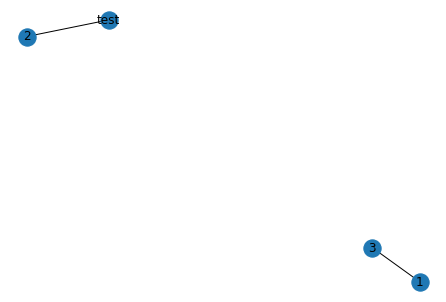

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
G.add_edge("test",2,)
G.add_edge(1,3)
nx.draw(G, with_labels=True)
plt.show()

In [8]:
from gensim import models
from collections import defaultdict
from gensim import corpora




documents = [
    "Human machine interface for lab abc computer applications",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering",
    "Graph minors A survey",
]


# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in documents
]

print(texts)

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

dictionary = corpora.Dictionary(texts)
print(dictionary)

corpus = [dictionary.doc2bow(text) for text in texts]
print(corpus)





tfidf = models.TfidfModel(corpus)  # step 1 -- initialize a model

corpus_tfidf = tfidf[corpus]
#for doc in corpus_tfidf:
#    print(doc)

lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)  # initialize an LSI transformation
corpus_lsi = lsi_model[corpus_tfidf]  # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

lsi_model.print_topics(2)

[['human', 'machine', 'interface', 'lab', 'abc', 'computer', 'applications'], ['survey', 'user', 'opinion', 'computer', 'system', 'response', 'time'], ['eps', 'user', 'interface', 'management', 'system'], ['system', 'human', 'system', 'engineering', 'testing', 'eps'], ['relation', 'user', 'perceived', 'response', 'time', 'error', 'measurement'], ['generation', 'random', 'binary', 'unordered', 'trees'], ['intersection', 'graph', 'paths', 'trees'], ['graph', 'minors', 'iv', 'widths', 'trees', 'well', 'quasi', 'ordering'], ['graph', 'minors', 'survey']]
Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...)
[[(0, 1), (1, 1), (2, 1)], [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(2, 1), (5, 1), (7, 1), (8, 1)], [(1, 1), (5, 2), (8, 1)], [(3, 1), (6, 1), (7, 1)], [(9, 1)], [(9, 1), (10, 1)], [(9, 1), (10, 1), (11, 1)], [(4, 1), (10, 1), (11, 1)]]


[(0,
  '0.703*"trees" + 0.538*"graph" + 0.402*"minors" + 0.187*"survey" + 0.061*"system" + 0.060*"time" + 0.060*"response" + 0.058*"user" + 0.049*"computer" + 0.035*"interface"'),
 (1,
  '-0.460*"system" + -0.373*"user" + -0.332*"eps" + -0.328*"interface" + -0.320*"time" + -0.320*"response" + -0.293*"computer" + -0.280*"human" + -0.171*"survey" + 0.161*"trees"')]

In [69]:
def concatenate(**words):
    z = "test"
    result = ""
    
    for arg in words.keys():
        print(arg.value())
    for arg in words.values():
        print(arg)
        result += arg
    return result

print(concatenate(a="Real", b="Python", c="Is", d="Great", e="!"))
#print(concatenate(a=10))

AttributeError: 'str' object has no attribute 'value'

In [1]:
import gensim.downloader as api

api.info()  # return dict with info about available models/datasets

{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1,
   'record_format': 'dict',
   'file_size': 6344358,
   'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py',
   'license': 'All files released for the task are free for general research use',
   'fields': {'2016-train': ['...'],
    '2016-dev': ['...'],
    '2017-test': ['...'],
    '2016-test': ['...']},
   'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.',
   'checksum': '701ea67acd82e75f95e1d8e62fb0ad29',
   'file_name': 'se